# Plots of Hughes et al. 2018 analysis

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import matplotlib.image as mpimg
import matplotlib as mp
import matplotlib.image as image
import sqlite3
import os

mp.rcParams['pdf.fonttype'] = 42
mp.rcParams['ps.fonttype'] = 42

# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def invlogit(x):
    return 1/(1+np.exp(-x))

def logit(x):
    return np.log(p/(1-p))

In [2]:
hdata = pd.read_csv('hughes_newdata.csv')
hdata.head()

,Unnamed: 0,ID,Region,Location,Lat,Long,Size_km2,Bleaching,Year
0,1980,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1980
1,1981,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1981
2,1982,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1982
3,1983,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1983
4,1984,1,Australasia,"Australia, Coral Sea Northern",16.5S,149.8E,1165,N,1984


In [3]:
year = hdata.Year.values.astype(int)
nyears = len(np.unique(year))
bleaching = (hdata.Bleaching.values=='S')*1

In [4]:
results = pd.read_csv('hughes_results.csv')
results.head()

,Unnamed: 0,Global_rate_c1980,Australasia_rate_c1980,Indian Ocean/ Middle East_rate_c1980,Pacific_rate_c1980,West Atlantic_rate_c1980,Site_rate_c1980__0,Site_rate_c1980__1,Site_rate_c1980__2,Site_rate_c1980__3,...,Site_rate_c1980__98,Site_rate_c1980__99,Global_trend,Australasia_trend,Indian Ocean/ Middle East_trend,Pacific_trend,West Atlantic_trend,σ0,σ00,σ1
0,0,-3.768745,-4.421566,-3.729993,-3.399257,-3.042053,-4.309559,-4.732952,-3.702948,-4.678414,...,-2.915812,-3.427213,0.041558,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.068722
1,1,-3.619518,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,...,-2.902203,-3.344546,0.089472,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.148554
2,2,-3.764437,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,...,-2.902203,-3.344546,0.024207,0.083745,0.053171,0.055289,0.015768,0.660769,0.449946,0.148554
3,3,-3.698988,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,...,-2.902203,-3.344546,0.195930,0.083745,0.053171,0.055289,0.015768,0.897088,0.463734,0.197399
4,4,-3.766547,-4.421566,-3.729993,-3.399257,-3.042053,-4.358131,-4.796994,-3.801010,-4.621623,...,-2.902203,-3.344546,0.195930,0.083745,0.053171,0.055289,0.015768,0.897088,0.463734,0.176345


In [5]:
# Grab parameter traces
α0 = results.Australasia_rate_c1980.values
a0 = np.median(α0)
α1 = results.Australasia_trend.values
a1 = np.median(α1)

In [6]:
xnew = np.linspace(0,nyears*2+1,nyears*2+1)
ynew = a0+a1*xnew
ynew_l95 = np.percentile(α0,2.5)+np.percentile(α1,2.5)*xnew
ynew_l50 = np.percentile(α0,25)+np.percentile(α1,25)*xnew
ynew_u50 = np.percentile(α0,75)+np.percentile(α1,75)*xnew
ynew_u95 = np.percentile(α0,97.5)+np.percentile(α1,97.5)*xnew

In [7]:
tmp = pd.DataFrame({'Year':np.round(xnew+1980).astype(int), 'PB':invlogit(ynew)})
tmp.head()

,Year,PB
0,1980,0.009506
1,1981,0.010391
2,1982,0.011358
3,1983,0.012413
4,1984,0.013565


In [8]:
tmp.to_csv('hughes_proj.csv')

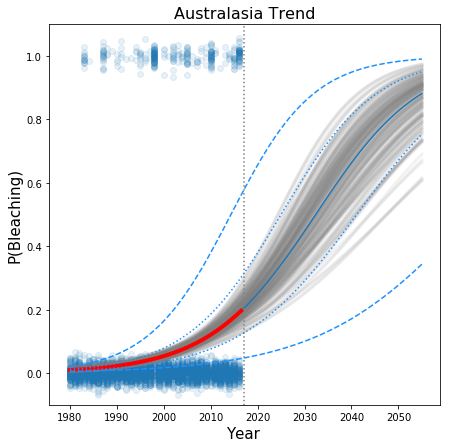

In [9]:
plt.figure(figsize=(7,7))
# Model fit
[plt.plot(xnew+1980,invlogit(α0[i]+α1[i]*xnew), alpha=0.1, color='grey', linewidth=3) for i in np.random.choice(len(α1), 200, replace=False)]
plt.plot(xnew+1980,invlogit(ynew))
plt.plot(xnew[xnew<37]+1980,invlogit(ynew[xnew<37]),linewidth=4,color='red')
# UIs
plt.plot(xnew+1980,invlogit(ynew_l50),color='dodgerblue',linestyle=":")
plt.plot(xnew+1980,invlogit(ynew_u50),color='dodgerblue',linestyle=":")
plt.plot(xnew+1980,invlogit(ynew_l95),color='dodgerblue',linestyle="--")
plt.plot(xnew+1980,invlogit(ynew_u95),color='dodgerblue',linestyle="--")

# Data
jit = np.random.normal(0,.02,len(year))
plt.scatter(year+jit**2,bleaching+jit,alpha=.1)
# Prettify
plt.plot((1980+nyears,1980+nyears),(-.5,1.5),linestyle=":", color='grey')
plt.ylim(-0.1,1.1)
# Labels
plt.xlabel('Year', fontsize=15)
plt.ylabel('P(Bleaching)', fontsize=15)
plt.title('Australasia Trend', fontsize=16)
plt.savefig('Figure_S4.pdf');